# Introduction


In this Kernel we introduce a general ML pipeline for text classification, with focus on what is specific for Chinese text.


# Analysis preparation

## Load packages

Most of the packages are usual ones used for simple NLP and classification; in this case, we are also imported **jieba**, a package for Chinese language basic NLP.


In [1]:
import numpy as np
import pandas as pd
import os
import json
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline 
from wordcloud import WordCloud, STOPWORDS
from joblib import Parallel, delayed
import tqdm
import jieba
import time
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, f1_score, recall_score

## Load data

The data contains news articles in Chinese simplified.

In [2]:
data_df = pd.read_csv("../input/chinese-official-daily-news-since-2016/chinese_news.csv")

## Glimpse the data

In [3]:
print(f"Rows: {data_df.shape[0]}, Cols: {data_df.shape[1]}")

Rows: 20738, Cols: 4


In [4]:
data_df.head()

,date,tag,headline,content
0,2016-01-01,详细全文,陆军领导机构火箭军战略支援部队成立大会在京举行 习近平向中国人民解放军陆军火箭军战略支援部队...,中国人民解放军陆军领导机构、中国人民解放军火箭军、中国人民解放军战略支援部队成立大会2015...
1,2016-01-01,详细全文,中央军委印发《关于深化国防和军队改革的意见》,经中央军委主席习近平批准，中央军委近日印发了《关于深化国防和军队改革的意见》。\n《意见》强...
2,2016-01-01,详细全文,《习近平关于严明党的纪律和规矩论述摘编》出版发行,由中共中央纪律检查委员会、中共中央文献研究室编辑的《习近平关于严明党的纪律和规矩论述摘编》一...
3,2016-01-01,详细全文,以实际行动向党中央看齐 向高标准努力,广大党员干部正在积极学习习近平总书记在中央政治局专题民主生活会上的重要讲话。大家纷纷表示要把...
4,2016-01-01,详细全文,【年终特稿】关键之年 改革挺进深水区,刚刚过去的2015年，是全面深化改革的关键之年。改革集中发力在制约经济社会发展的深层次矛盾，...


# Data exploration



In [5]:
print(f"Samples with content null: {data_df.loc[data_df['content'].isnull()].shape[0]}")

Samples with content null: 107


In [6]:
print(f"Samples with headline null: {data_df.loc[data_df['headline'].isnull()].shape[0]}")

Samples with headline null: 0


Let's drop the rows will null content. We will not include in the analysis the samples with articles without content.

In [7]:
data_df = data_df.loc[~data_df['content'].isnull()]

In [8]:
print(f"New data shape: {data_df.shape}")

New data shape: (20631, 4)


## Visualization utility


We download the fonts to display the Chinese characters.

In [9]:
!wget https://github.com/adobe-fonts/source-han-sans/raw/release/SubsetOTF/SourceHanSansCN.zip
!unzip -j "SourceHanSansCN.zip" "SourceHanSansCN/SourceHanSansCN-Regular.otf" -d "."
!rm SourceHanSansCN.zip
!ls

wget: /opt/conda/lib/libuuid.so.1: no version information available (required by wget)
--2020-01-25 14:48:26--  https://github.com/adobe-fonts/source-han-sans/raw/release/SubsetOTF/SourceHanSansCN.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/adobe-fonts/source-han-sans/release/SubsetOTF/SourceHanSansCN.zip [following]
--2020-01-25 14:48:26--  https://raw.githubusercontent.com/adobe-fonts/source-han-sans/release/SubsetOTF/SourceHanSansCN.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52351259 (50M) [application/zip]
Saving to: ‘SourceHanSansCN.zip’

SourceHanSansCN.zip 100%[===============

Then we load the font from the downloaded resource.

In [10]:
import matplotlib.font_manager as fm
font_path = './SourceHanSansCN-Regular.otf'
prop = fm.FontProperties(fname=font_path)

## Target distribution

In [11]:
def plot_count(feature, title, df, font_prop=prop, size=1):
    f, ax = plt.subplots(1,1, figsize=(4*size,4))
    total = float(len(df))
    g = sns.countplot(df[feature], order = df[feature].value_counts().index[:20], palette='Set3')
    g.set_title("Number and percentage of {}".format(title))
    if(size > 2):
        plt.xticks(rotation=90, size=8)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height/total),
                ha="center") 
    ax.set_xticklabels(ax.get_xticklabels(), fontproperties=font_prop);
    plt.show()    

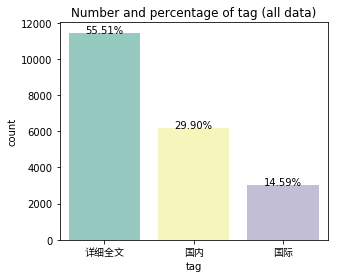

In [12]:
plot_count('tag', 'tag (all data)', font_prop=prop, df=data_df,size=1.2)

## Date info extraction


We extract from the data the year, month and day of week.

In [13]:
data_df['datetime'] = data_df['date'].apply(lambda x: pd.to_datetime(x))
data_df['year'] = data_df['datetime'].dt.year
data_df['month'] = data_df['datetime'].dt.month
data_df['dayofweek'] = data_df['datetime'].dt.dayofweek

## Cut phrases in ideograms groups

Chinese does not have flexionary forms and also does not use spaces between ideograms to mark separate words. In the same time, some concepts are using 2 ore more ideograms in a sequence. The reader will `cut` in mind during reading the sequences of ideograms in groups, corresponding to different concepts, based on context. 
We will use **jieba** library to separate the ideograms in groups.

In [14]:
def jieba_cut(x, sep=' '):
    return sep.join(jieba.cut(x, cut_all=False))

print('raw', data_df['headline'][0])
print('cut', jieba_cut(data_df['headline'][0], ', '))

Building prefix dict from the default dictionary ...


raw 陆军领导机构火箭军战略支援部队成立大会在京举行 习近平向中国人民解放军陆军火箭军战略支援部队授予军旗并致训词


Dumping model to file cache /tmp/jieba.cache
Loading model cost 1.598 seconds.
Prefix dict has been built succesfully.


cut 陆军, 领导, 机构, 火箭, 军, 战略, 支援, 部队, 成立, 大会, 在京举行,  , 习近平, 向, 中国人民解放军, 陆军, 火箭, 军, 战略, 支援, 部队, 授予, 军旗, 并致, 训词


We apply now the above defined function to the whole dataset. We are doing this for both the content and headline features.

In [15]:
%%time
data_df['headline_cut'] = Parallel(n_jobs=4)(
    delayed(jieba_cut)(x) for x in tqdm.tqdm_notebook(data_df['headline'].values)
)


CPU times: user 1.56 s, sys: 97 ms, total: 1.66 s
Wall time: 5.3 s


In [16]:
%%time
data_df['content_cut'] = Parallel(n_jobs=4)(
    delayed(jieba_cut)(x) for x in tqdm.tqdm_notebook(data_df['content'].values)
)


CPU times: user 2.81 s, sys: 170 ms, total: 2.98 s
Wall time: 21.4 s


In [17]:
prop = fm.FontProperties(fname=font_path, size=20)

After we cut the ideograms sequences in groups (each corresponding to one concept - or token) we represent the most frequenty used with wordclouds.

In [18]:

stopwords = set(STOPWORDS)

def show_wordcloud(data, font_path=font_path, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        font_path=font_path,
        max_words=50,
        max_font_size=40, 
        scale=5,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(10,10))
    plt.axis('off')
    if title: 
        prop = fm.FontProperties(fname=font_path)
        fig.suptitle(title, fontsize=40, fontproperties=prop)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

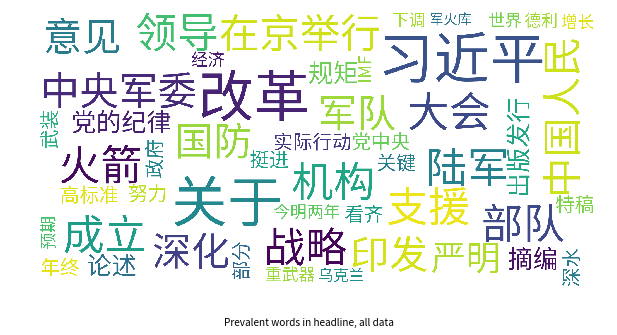

In [19]:
show_wordcloud(data_df['headline_cut'], font_path, title = 'Prevalent words in headline, all data')

In [20]:
data_df.tag.unique()

array(['详细全文', '国内', '国际'], dtype=object)

We show now the most frequent groups of ideograms grouped by target value (or tag).

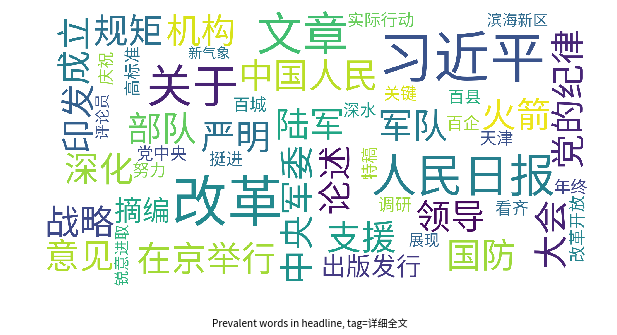

In [21]:
data_tag_df = data_df.loc[data_df.tag=='详细全文']
show_wordcloud(data_tag_df['headline_cut'], font_path, title = 'Prevalent words in headline, tag=详细全文')

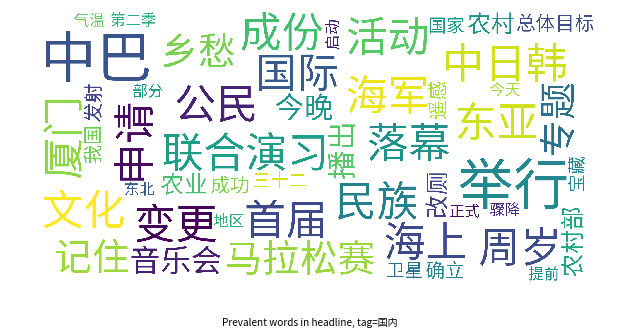

In [22]:
data_tag_df = data_df.loc[data_df.tag=='国内']
show_wordcloud(data_tag_df['headline_cut'], font_path, title = 'Prevalent words in headline, tag=国内')

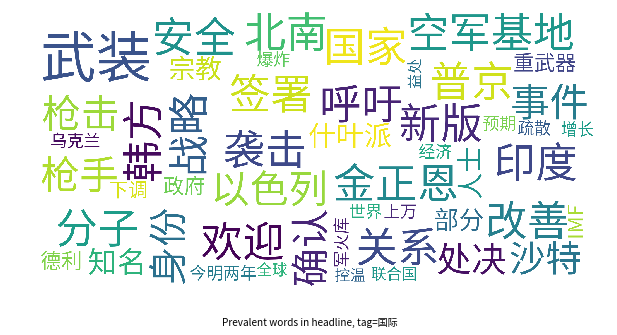

In [23]:
data_tag_df = data_df.loc[data_df.tag=='国际']
show_wordcloud(data_tag_df['headline_cut'], font_path, title = 'Prevalent words in headline, tag=国际')

# Split data to train-test

In [24]:
train_df, test_df = train_test_split(data_df, test_size = 0.2, random_state = 42) 

In [25]:
print(f"train: {train_df.shape}, test: {test_df.shape}")

train: (16504, 10), test: (4127, 10)


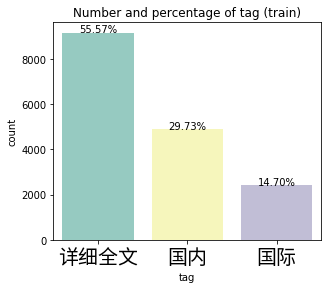

In [26]:
plot_count('tag', 'tag (train)', font_prop=prop, df=train_df,size=1.2)

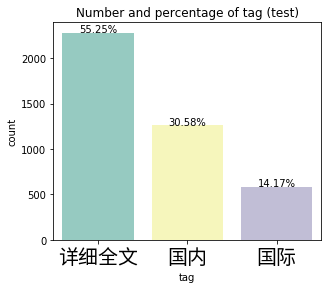

In [27]:
plot_count('tag', 'tag (test)', font_prop=prop, df=test_df,size=1.2)

# Text preprocessing

In [28]:
train_df.head()

,date,tag,headline,content,datetime,year,month,dayofweek,headline_cut,content_cut
6293,2016-12-02,国际,日本扑杀家禽 防范禽流感疫情,日本农林水产省12月1日发布消息称，在新潟县关川村和青森市检出的病毒经鉴定为“H5N6”型禽...,2016-12-02,2016,12,4,日本 扑杀 家禽 防范 禽流感 疫情,日本 农林水产 省 12 月 1 日 发布 消息 称 ， 在 新 潟 县 关川村 和 青森 ...
9433,2017-04-29,详细全文,【大国工匠 传心创世】潘从明：滴水掘金 精炼人生,超级工程离不开超级工艺，更少不了掌握超级技能的劳动者。有这样一群人，他们在喧嚣中秉持一颗安于...,2017-04-29,2017,4,5,【 大国 工匠 传心 创世 】 潘从明 ： 滴水 掘金 精炼 人生,超级 工程 离不开 超级 工艺 ， 更 少不了 掌握 超级 技能 的 劳动者 。 有 这样 ...
6154,2016-11-26,详细全文,国务院调查组赴河北 江苏查处去产能违法违规行为,按照国务院部署，国务院两个调查组日前已分赴河北和江苏，就钢铁行业去产能工作中个别企业存在的顶...,2016-11-26,2016,11,5,国务院 调查组 赴 河北 江苏 查处 去 产能 违法 违规行为,按照 国务院 部署 ， 国务院 两个 调查组 日前 已 分赴 河北 和 江苏 ， 就 钢铁行...
15922,2018-02-26,详细全文,铁路客流高位运行 海口已无旅客滞留,全国铁路今天预计发送旅客1042万人次。为应对客流高峰，南昌铁路局今天加开列车83趟。沈阳铁...,2018-02-26,2018,2,0,铁路 客流 高位 运行 海口 已 无 旅客 滞留,全国 铁路 今天 预计 发送 旅客 1042 万人次 。 为 应对 客流 高峰 ， 南昌铁路...
19128,2018-07-27,详细全文,习近平会见阿根廷总统,国家主席习近平当地时间26日在南非约翰内斯堡会见阿根廷总统马克里。\n习近平指出，当前，单边...,2018-07-27,2018,7,4,习近平 会见 阿根廷 总统,国家 主席 习近平 当地 时间 26 日 在 南非 约翰内斯堡 会见 阿根廷 总统 马克里 ...


In [29]:
def count_vect_feature(feature, df, max_features=5000):
    start_time = time.time()
    cv = CountVectorizer(max_features=max_features,
                             ngram_range=(1, 1),
                             stop_words='english')
    X_feature = cv.fit_transform(df[feature])
    print('Count Vectorizer `{}` completed in {} sec.'.format(feature, round(time.time() - start_time,2)))
    return X_feature, cv

In [30]:
X_headline, cv = count_vect_feature('headline_cut', train_df, 20000)

Count Vectorizer `headline_cut` completed in 0.37 sec.


In [31]:
X_content, cv = count_vect_feature('content_cut', train_df, 30000)

Count Vectorizer `content_cut` completed in 3.81 sec.


# Model

In [32]:
target =  'tag'
X = X_content
y = train_df[target].values
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size = 0.2, random_state = 42) 

In [33]:
train_X.shape, valid_X.shape, train_y.shape, valid_y.shape

((13203, 30000), (3301, 30000), (13203,), (3301,))

## SVC Model


We use first a SVC model (with linear kernel).


### Model fit

In [34]:
%%time
clf_svc = SVC(kernel='linear')
clf_svc = clf_svc.fit(train_X, train_y)

CPU times: user 1min 9s, sys: 525 ms, total: 1min 9s
Wall time: 1min 9s


### Model validation

In [35]:
def show_confusion_matrix(valid_y, predicted, size=1, font_prop=prop, trim_labels=False):
    mat = confusion_matrix(valid_y, predicted)
    plt.figure(figsize=(4*size, 4*size))
    f, ax = plt.subplots(1,1, figsize=(4*size,4*size))
    sns.set()
    target_labels = np.unique(valid_y)
    if(trim_labels):
        target_labels = [x[0:70] for x in target_labels]
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=target_labels,
                yticklabels=target_labels
               )
    ax.set_xticklabels(ax.get_xticklabels(), fontproperties=font_prop);
    ax.set_yticklabels(ax.get_yticklabels(), fontproperties=font_prop);
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    plt.show()

Valid:
Feature: tag 	| Prediction accuracy: 0.8009694032111482
Feature: tag 	| Prediction F1-score: 0.8032514538665663
Feature: tag 	| Prediction recall: 0.8009694032111482


<Figure size 432x432 with 0 Axes>

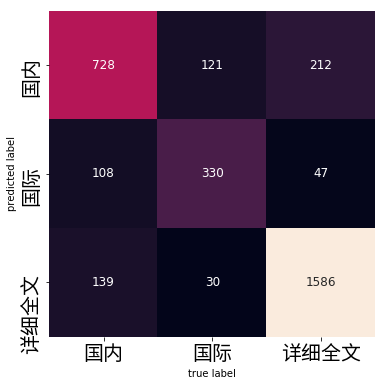

              precision    recall  f1-score   support

          国内       0.69      0.75      0.72       975
          国际       0.68      0.69      0.68       481
        详细全文       0.90      0.86      0.88      1845

    accuracy                           0.80      3301
   macro avg       0.76      0.76      0.76      3301
weighted avg       0.81      0.80      0.80      3301



In [36]:
predicted_valid = clf_svc.predict(valid_X)
prediction_acc = np.mean(predicted_valid == valid_y)
prediction_f1_score = f1_score(valid_y, predicted_valid, average='weighted')
prediction_recall = recall_score(valid_y, predicted_valid, average='weighted')
print("Valid:\n========================================================")
print(f"Feature: {target} \t| Prediction accuracy: {prediction_acc}")
print(f"Feature: {target} \t| Prediction F1-score: {prediction_f1_score}")
print(f"Feature: {target} \t| Prediction recall: {prediction_recall}")
show_confusion_matrix(valid_y, predicted_valid, font_prop=prop,size=1.5)
print(classification_report(valid_y, predicted_valid))

## MultinomialNB model

In [37]:
%%time
clf_nb = MultinomialNB(fit_prior='true')
clf_nb = clf_nb.fit(train_X, train_y)

CPU times: user 79.8 ms, sys: 2 ms, total: 81.8 ms
Wall time: 86 ms


Valid:
Feature: tag 	| Prediction accuracy: 0.7570433202059982
Feature: tag 	| Prediction F1-score: 0.7622766455085508
Feature: tag 	| Prediction recall: 0.7570433202059982


<Figure size 432x432 with 0 Axes>

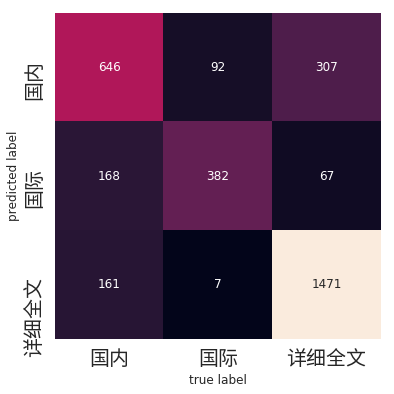

              precision    recall  f1-score   support

          国内       0.62      0.66      0.64       975
          国际       0.62      0.79      0.70       481
        详细全文       0.90      0.80      0.84      1845

    accuracy                           0.76      3301
   macro avg       0.71      0.75      0.73      3301
weighted avg       0.77      0.76      0.76      3301



In [38]:
predicted_valid = clf_nb.predict(valid_X)
prediction_acc = np.mean(predicted_valid == valid_y)
prediction_f1_score = f1_score(valid_y, predicted_valid, average='weighted')
prediction_recall = recall_score(valid_y, predicted_valid, average='weighted')
print("Valid:\n========================================================")
print(f"Feature: {target} \t| Prediction accuracy: {prediction_acc}")
print(f"Feature: {target} \t| Prediction F1-score: {prediction_f1_score}")
print(f"Feature: {target} \t| Prediction recall: {prediction_recall}")
show_confusion_matrix(valid_y, predicted_valid, font_prop=prop,size=1.5)
print(classification_report(valid_y, predicted_valid))

# Conclusion


We used two different models: MultinomialNB (based on Naive Bayes) and SCV (based on SVM).

SVC model performed better, with weighted and macro average scores for performance, recall and f1-score (and corresponding scores per class) better than for MultinomialNB scores.